In [126]:
from tika import parser
import re
import timeit
import os
import pandas as pd
import string

## Clean data##

In [144]:
def generate_raw_data():
    
    """
    This function generates raw text data from FOMC transcripts
    
    returns a list where each element is the full text within each FOMC meeting
    
    It will take about 4-5 minutes
    """

    cwd = os.getcwd() # get current working directory
    base_directory = './FOMC_pdf' # set directory of pdfs
    raw_doc = os.listdir(base_directory) # as above
    filelist = sorted(raw_doc) # sort the pdfs in order
    onlyfiles = [f for f in raw_doc if os.path.isfile(os.path.join(base_directory, f))] # keep if in correct dir
    date = [f[4:10] for f in onlyfiles] # keep the dates in pdfs

    raw_text = pd.DataFrame(columns = ['Date','Speaker', 'content']) #empty dataframe

    start = timeit.default_timer()
    for i,file in enumerate(filelist):
        print('Document {} of {}'.format(i, len(filelist)))
        
        parsed = parser.from_file(os.path.join(cwd, 'FOMC_pdf',file)) # parse the pdf
        interjections = re.split('\nMR. |\nMS. |\nCHAIRMAN |\nVICE CHAIRMAN ', parsed['content']) # split the entire string by the names (looking for MR, MS, Chairman or Vice Chairman)
        temp_df = pd.DataFrame(columns = ['Date','Speaker','content']) # create a temporary dataframe
        interjections = [interjection.replace('\n',' ') for interjection in interjections] # replace \n linebreaks with spaces
        temp = [re.split('(^\S*)', interjection.lstrip()) for interjection in interjections] # changed to this split because sometimes (rarely) there was not a period, either other punctuation or whitespace
        
        speaker = []
        content = []
        for interjection in temp:
            speaker.append(interjection[1].strip(string.punctuation))
            content.append(interjection[2])
            
        temp_df['Speaker'] = speaker

        temp_df['content'] = content # save interjections

        temp_df['Date'] = date[i]
        raw_text = pd.concat([raw_text, temp_df], ignore_index = True)

    end = timeit.default_timer()
    raw_text.index = raw_text['Date'] # set dataframe index to the Date
    raw_text.to_excel('raw_text.xlsx') # save as raw_text.xlsx

    print("Documents processed. Time: {}".format(end - start))
    
    return raw_text


In [292]:
import pandas as pd
import topicmodels
import numpy as np
from nltk.stem import PorterStemmer
import nltk
from nltk.collocations import *

def preprocess():
    
    
    '''
    main function for preprocessing
        
    This function writes the tokenized documents, which includes columns of 
    
    Date: date of the meeting
    Section: FOMC1 or FOMC2
    Speaker: speaker of the interjection
    content: list of tokens in the interjection
    
    '''
    
    
    text = pd.read_excel('raw_text.xlsx')
    
    text_separated = separation(text)
    
    text_separated_col = find_collocation(text_separated)
    text_separated_col['content'] = tokenize(text_separated_col['content'].values)
    text_separated_col.to_excel('FOMC_token_separated_col.xlsx')
    
def tokenize(content):
    '''
    Code for tokenization:
        1. remove words with length of 1
        2. remove non-alphabetical words
        3. remove stop words
        4. stem all words
    '''
    FOMC_token = []
    for statement in content:
        statement = statement.lower()
        docsobj = topicmodels.RawDocs([statement], "long")
        docsobj.token_clean(1)
        docsobj.stopword_remove("tokens")
        docsobj.stem()
        docsobj.stopword_remove("stems")
        ps = PorterStemmer()
        FOMC_token.append(' '.join([ps.stem(word) for word in docsobj.tokens[0]]))
        
    return FOMC_token

def separation(raw_text):
    
    separation_rule = pd.read_excel('Separation.xlsx')
    
    FOMC_separation = pd.DataFrame(columns = ['Date','Speaker','content','Section'])
    for i in separation_rule.index:

        temp1 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC1_start'][i]:separation_rule['FOMC1_end'][i]]
        temp1['Section'] = 1
        if separation_rule['FOMC2_end'][i] == 'end':
            temp2 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC2_start'][i]:]
        else:
            temp2 = raw_text[raw_text["Date"] == i].iloc[separation_rule['FOMC2_start'][i]:separation_rule['FOMC2_end'][i]]
        temp2['Section'] = 2
        FOMC_separation = FOMC_separation.append(temp1, ignore_index=True)
        FOMC_separation = FOMC_separation.append(temp2, ignore_index = True)
        
    FOMC_separation.to_excel('raw_text_separated.xlsx')
    return FOMC_separation

def find_collocation(raw_text_separated):
    
    content = raw_text_separated['content'].apply(lambda x: re.sub(r'[^\w\s]','',x)) #remove punctuations
    
    big_document = content.apply(lambda x: x.split(' ')).values
    
    bigram_list = bigrams(big_document)
    trigram_list = trigram(big_document)
    
    replace_word = [''.join(x.split(' ')) + 'xx' for x in bigram_list] + [''.join(x.split(' ')) + 'xxx' for x in trigram_list]
    
    dict_collocation = dict(zip(bigram_list + trigram_list, replace_word))

    content = content.apply(lambda x: replace_collocation(x, dict_collocation))
    
    raw_text_separated['content'] = content
    raw_text_separated.to_excel('FOMC_separated_Collocation.xlsx')
    return raw_text_separated

def bigrams(big_document):
    
    ignored_words = nltk.corpus.stopwords.words('english')
    ignored_words.append('percent')
    ignored_words.append('governor')
    ignored_words.append('dont')
    bigram_measures = nltk.collocations.BigramAssocMeasures()

    finder = BigramCollocationFinder.from_documents(big_document)
    finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
    finder.apply_freq_filter(150)
    
    return [' '.join(x) for x in list(finder.ngram_fd.keys())]


def trigram(big_document):
    
    ignored_words = nltk.corpus.stopwords.words('english')
    ignored_words.append('percent')
    ignored_words.append('governor')
    ignored_words.append('dont')
    trigram_measures = nltk.collocations.TrigramAssocMeasures()

    finder = TrigramCollocationFinder.from_documents(big_document)
    finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)
    finder.apply_freq_filter(100)
    
    return [' '.join(x) for x in list(finder.ngram_fd.keys())]

def replace_collocation(string, dict_collocation):
    
    for key in dict_collocation.keys():
        
        string = string.replace(key, dict_collocation[key])
        
    return string

In [428]:
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt

def generate_term_document(option = None):
    '''
    option = 'text' or 'matrix' for return options
    
    '''
    data = pd.read_excel('FOMC_token_separated_col.xlsx')
    texts = []
    for line in data['content'].fillna(' ').values:
        texts.append(line.split(' '))
        
    dictionary2 = corpora.Dictionary(texts)
    corpus2 = [dictionary2.doc2bow(text) for text in texts]
    
    term_document2 = gensim.matutils.corpus2dense(corpus2, num_terms=len(dictionary2.keys()))
    
    TF = 1+np.log(term_document2.sum(axis = 1))
    IDF = np.log(term_document2.shape[1] / np.count_nonzero(term_document2, axis = 1))

    TF_IDF = pd.Series(dict(zip(dictionary2.keys(), TF*IDF)))
    
    # use top 9000 in TF-IDF
    keys_to_use2 = TF_IDF.sort_values(ascending = False)[:9000].index.values
    
    TF_IDF.sort_values(ascending = False).reset_index()[0].plot()
    plt.show()
    
    dictionary2.filter_tokens(good_ids = keys_to_use2)
    
    #pd.Series(dictionary2.token2id).to_csv('dictionary.csv')
    
    new_text = []
    for line in texts:
        new_text.append([x for x in line if x in dictionary2.token2id.keys()])
    
    new_corpus2 = [dictionary2.doc2bow(text) for text in texts]
    new_term_document2 = gensim.matutils.corpus2dense(new_corpus2, num_terms=len(dictionary2.keys()))
    
    #pd.DataFrame(new_term_document2).to_csv('Matrix_interjection_tfidf.csv')
    
    if option == 'text':
        return new_text
    elif option == 'matrix':
        return new_term_document2
    else:
        return None

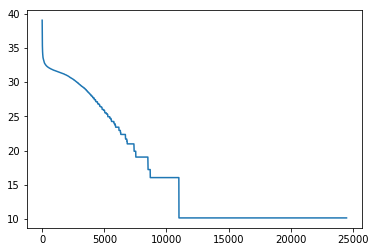

In [429]:
text = generate_term_document('text')

## LDA Implementation##

In [318]:
import topicmodels

In [368]:
topicmodels.LDA.LDAGibbs?

In [371]:
# 40 topics
ldaobj = topicmodels.LDA.LDAGibbs(text,40)

In [372]:
# Gibbs sampling
ldaobj.sample(100,50,10)

Iteration 10 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 30 of (collapsed) Gibbs sampling
Iteration 40 of (collapsed) Gibbs sampling
Iteration 50 of (collapsed) Gibbs sampling
Iteration 60 of (collapsed) Gibbs sampling
Iteration 70 of (collapsed) Gibbs sampling
Iteration 80 of (collapsed) Gibbs sampling
Iteration 90 of (collapsed) Gibbs sampling
Iteration 100 of (collapsed) Gibbs sampling
Iteration 110 of (collapsed) Gibbs sampling
Iteration 120 of (collapsed) Gibbs sampling
Iteration 130 of (collapsed) Gibbs sampling
Iteration 140 of (collapsed) Gibbs sampling
Iteration 150 of (collapsed) Gibbs sampling
Iteration 160 of (collapsed) Gibbs sampling
Iteration 170 of (collapsed) Gibbs sampling
Iteration 180 of (collapsed) Gibbs sampling
Iteration 190 of (collapsed) Gibbs sampling
Iteration 200 of (collapsed) Gibbs sampling
Iteration 210 of (collapsed) Gibbs sampling
Iteration 220 of (collapsed) Gibbs sampling
Iteration 230 of (collapsed) Gibbs sampli

In [376]:
# theta matrix
ldaobj.dt_avg()

array([[0.02358491, 0.02924528, 0.02358491, ..., 0.02358491, 0.02358491,
        0.02358491],
       [0.02272727, 0.05363636, 0.02272727, ..., 0.02272727, 0.02272727,
        0.02636364],
       [0.02647059, 0.03235294, 0.0245098 , ..., 0.0245098 , 0.0245098 ,
        0.0245098 ],
       ...,
       [0.0221519 , 0.0943038 , 0.01962025, ..., 0.03607595, 0.01708861,
        0.01962025],
       [0.02403846, 0.02403846, 0.02403846, ..., 0.02403846, 0.02403846,
        0.02403846],
       [0.01607143, 0.12559524, 0.01607143, ..., 0.02083333, 0.01488095,
        0.01607143]])

In [379]:
# B matrix
ldaobj.tt_avg()

array([[4.50868051e-07, 8.20897305e-07, 5.23757390e-07, ...,
        5.73871215e-07, 4.77690828e-07, 6.60305428e-07],
       [1.99252556e-03, 8.20897305e-07, 1.34451101e-02, ...,
        5.73871215e-07, 4.77690828e-07, 6.60305428e-07],
       [1.31936203e-03, 8.20897305e-07, 2.76601041e-06, ...,
        5.73871215e-07, 1.70784621e-03, 3.67407837e-06],
       ...,
       [1.66711393e-05, 3.49876065e-04, 5.41403683e-06, ...,
        5.73871215e-07, 4.77690828e-07, 6.60305428e-07],
       [6.51932019e-06, 8.20897305e-07, 5.23757390e-07, ...,
        2.91732828e-06, 4.81985323e-06, 1.27852711e-03],
       [2.48322314e-06, 8.55993689e-06, 5.23757390e-07, ...,
        5.73871215e-07, 8.38732050e-05, 3.67407837e-06]])

## NMF with ANLS

using numba

In [382]:
import numba
@numba.jit
def NMF_ANLS_full(P,k):

    B = np.random.uniform(low = 1, high = 1000,size = (P.shape[0], k))
    B = B/B.sum(axis = 0)

    return B, NMF_ANLS(B,P)

@numba.jit
def NMF_ANLS(B, P):
    
    theta = np.zeros(shape = (B.shape[1],P.shape[1]))
    
    for i,column in enumerate(P.T):
        theta[:,i] = ANLS_column(B, column)
        
    return theta

@numba.jit
def ANLS_column(B, y):
    
    m,n = B.shape
    g = np.zeros(n)
    E = np.arange(n)
    S = np.array([])
    w = np.matmul(B.T, y-np.matmul(B,g))
    

    while len(E) != 0 and w[E].max() > 0:
        
        t = w[E].argmax()
        E = np.delete(E, t).astype(int)
        S = np.append(S,t).astype(int)
        
        Bs = B.copy()
        Bs[:,E] = 0
        
        z = np.linalg.lstsq(Bs, y, rcond=None)[0]
        z[E] = 0

        while z[S].max() <= 0:
            
            alpha = (g/(g-z))[S].min()
            
            g = g + alpha*(z-g)
            
            s_move = S[g[S] == 0]
            S = np.delete(S, s_move).astype(int)
            E = np.append(E, s_move).astype(int)
            Bs = B.copy()
            Bs[:,E] = 0            
            z = np.linalg.lstsq(Bs, y, rcond=None)[0]
            #z[E] = 0
        g = z
        w = np.matmul(B.T, y-np.matmul(B,g))
    
    return g

In [387]:
td_matrix_pd = pd.read_csv('Matrix_interjection_tfidf.csv')
td_matrix_pd = td_matrix_pd.replace(0,1e-10)
td_matrix = td_matrix_pd.values
td_matrix = td_matrix / td_matrix.sum(axis = 0)

In [388]:
%%time
B, theta = NMF_ANLS_full(td_matrix, 40)

Wall time: 37min 59s


In [390]:
B

array([[2.19718208e-04, 3.93571793e-05, 1.07589936e-04, ...,
        1.05391241e-04, 1.60764049e-04, 1.49846546e-04],
       [5.09108670e-05, 5.73868558e-05, 1.64714438e-04, ...,
        1.66758255e-04, 1.51094051e-04, 1.32195319e-04],
       [9.97753619e-05, 3.79426938e-05, 1.54162546e-04, ...,
        1.63566411e-04, 7.51839910e-05, 2.02922270e-04],
       ...,
       [3.89136061e-05, 1.10068356e-04, 3.79175898e-05, ...,
        4.79770315e-05, 3.20093167e-05, 1.81468919e-05],
       [1.09339532e-04, 9.88638699e-06, 1.49133855e-04, ...,
        7.30981828e-05, 4.97122240e-06, 4.31877120e-05],
       [4.70511656e-05, 8.90459788e-05, 6.47713425e-05, ...,
        1.66646211e-04, 5.70052184e-05, 1.13227763e-04]])

In [391]:
theta

array([[0.01700569, 0.        , 0.06449576, ..., 0.        , 0.        ,
        0.36436682],
       [0.02302282, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02848518, 0.        , 0.        , ..., 0.04541429, 0.        ,
        0.        ],
       ...,
       [0.01864526, 0.        , 0.        , ..., 0.        , 0.        ,
        0.03785548],
       [0.02085815, 0.        , 0.96290561, ..., 0.        , 0.        ,
        0.        ],
       [0.02565627, 0.30553623, 0.        , ..., 0.        , 0.        ,
        0.        ]])